<a href="https://colab.research.google.com/github/Piyushiitk24/dc-motor-signed-bias-deadzone-id-control/blob/main/DC_Motor_ID_SignedBias_DeadZone_IMCPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SECTION 0 — Setup & Mount Drive

In [4]:
# --- SECTION 0: Setup & Mount Drive ---
import warnings; warnings.filterwarnings('ignore')

# Mount Google Drive (works in Colab; no-op elsewhere)
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

# Paths (edit if needed)
CSV_PATH  = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/run_minimal.csv'
MAP_PATH  = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/Voltage_PWM_RPM_Mapping.csv'
OUT_DIR   = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis'

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, lsim, TransferFunction
from scipy.interpolate import PchipInterpolator
from numpy.polynomial import Chebyshev

print("Setup complete.")

Mounted at /content/drive
Setup complete.


## SECTION 1 — Load Voltage–PWM–RPM Mapping + Build Mappers

In [6]:
# --- SECTION 1: Load Voltage–PWM–RPM Mapping + Build Mappers ---

# Load mapping table
map_df = pd.read_csv(MAP_PATH)

# Normalize column names (accepts any case)
map_df.columns = [c.strip().lower() for c in map_df.columns]
required = {'voltage','pwm','rpm'}
assert required.issubset(set(map_df.columns)), f"Mapping CSV must contain columns: {required}"

# Keep the three columns, sort by voltage, average duplicates (helps interpolation)
map_df = (map_df[['voltage','pwm','rpm']]
          .dropna()
          .groupby('voltage', as_index=False)
          .agg({'pwm':'median','rpm':'median'})
          .sort_values('voltage')
          .reset_index(drop=True))

V_map = map_df['voltage'].to_numpy(dtype=float)
P_map = map_df['pwm'].to_numpy(dtype=float)
R_map = map_df['rpm'].to_numpy(dtype=float)

# --- 1A) Shape-preserving LUTs (recommended) ---
# Voltage -> PWM (primary mapper for control)
pchip_V2P = PchipInterpolator(V_map, P_map, extrapolate=True)
# PWM -> Voltage (useful for cross-checks/tools)
# For reverse mapping, sort by PWM and average duplicates
_rev = (pd.DataFrame({'pwm':P_map,'voltage':V_map})
        .groupby('pwm', as_index=False).agg({'voltage':'median'})
        .sort_values('pwm').reset_index(drop=True))
pchip_P2V = PchipInterpolator(_rev['pwm'].to_numpy(float),
                              _rev['voltage'].to_numpy(float),
                              extrapolate=True)

# --- 1B) Optional explicit function (Chebyshev polynomial) ---
# Pick degree via BIC to avoid silly overfit while staying precise (deg 3..8)
def fit_cheby_bic(x, y, deg_range=range(3,9)):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x)
    best = {'deg': None, 'bic': np.inf, 'model': None}
    dom = [float(x.min()), float(x.max())]
    for deg in deg_range:
        ch = Chebyshev.fit(x, y, deg=deg, domain=dom)
        yhat = ch(x)
        rss = float(np.sum((y - yhat)**2))
        p = deg + 1  # number of coefficients
        # BIC = n*ln(RSS/n) + p*ln(n)
        bic = n*np.log(rss/max(n,1)) + p*np.log(max(n,1))
        if bic < best['bic']:
            best = {'deg': deg, 'bic': bic, 'model': ch}
    return best

cheby_fit = fit_cheby_bic(V_map, P_map)  # Voltage -> PWM
cheby_model = cheby_fit['model']  # can be None if something odd happens

# --- 1C) Deadband estimate from mapping (RPM threshold) ---
RPM_THRESHOLD = 30.0  # change if your motor "starts moving" at a different RPM
candidates = map_df.loc[map_df['rpm'] >= RPM_THRESHOLD, 'voltage']
V_DEADBAND_EST = float(candidates.iloc[0]) if len(candidates) else float(map_df['voltage'].min())

print(f"Mapping rows: {len(map_df)} | Deadband estimate ≈ {V_DEADBAND_EST:.2f} V | Chebyshev degree: {cheby_fit['deg']}")

Mapping rows: 40 | Deadband estimate ≈ 2.08 V | Chebyshev degree: 5


## SECTION 2 — Unified Mapping API (+ quick check)

In [7]:
# --- SECTION 2: Unified Voltage→PWM / PWM→Voltage mapping API ---

def _clip_pwm(x):
    return np.clip(np.asarray(x, dtype=float), 0, 255)

def _to_1d(a):
    return np.asarray(a, dtype=float).reshape(-1)

# Default deadband used by the mapper (you can override per call)
VDB_POS_DEFAULT = 4.5  # your original constant
VDB_NEG_DEFAULT = 4.5  # your original constant
USE_AUTO_DEADBAND = False  # set True to use the estimate from mapping

def voltage_to_pwm_lookup(v, vdb_pos=None, vdb_neg=None, round_to_int=True):
    v = _to_1d(v)
    vdb_pos = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_pos is None) else (vdb_pos if vdb_pos is not None else VDB_POS_DEFAULT)
    vdb_neg = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_neg is None) else (vdb_neg if vdb_neg is not None else VDB_NEG_DEFAULT)
    vdb = np.where(v >= 0.0, vdb_pos, vdb_neg)
    pwm = np.where(np.abs(v) < vdb, 0.0, pchip_V2P(v))
    pwm = _clip_pwm(pwm)
    return pwm.astype(int) if round_to_int else pwm

def voltage_to_pwm_cheby(v, vdb_pos=None, vdb_neg=None, round_to_int=True):
    assert cheby_model is not None, "Chebyshev model not available."
    v = _to_1d(v)
    vdb_pos = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_pos is None) else (vdb_pos if vdb_pos is not None else VDB_POS_DEFAULT)
    vdb_neg = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_neg is None) else (vdb_neg if vdb_neg is not None else VDB_NEG_DEFAULT)
    vdb = np.where(v >= 0.0, vdb_pos, vdb_neg)
    pwm = np.where(np.abs(v) < vdb, 0.0, cheby_model(v))
    pwm = _clip_pwm(pwm)
    return pwm.astype(int) if round_to_int else pwm

def pwm_to_voltage_lookup(pwm):
    pwm = _to_1d(pwm)
    return pchip_P2V(_clip_pwm(pwm))

def voltage_to_pwm(v, method='lookup', **kwargs):
    """method: 'lookup' (PCHIP, recommended) or 'cheby' (explicit polynomial)."""
    if method == 'lookup':
        return voltage_to_pwm_lookup(v, **kwargs)
    elif method == 'cheby':
        return voltage_to_pwm_cheby(v, **kwargs)
    else:
        raise ValueError("method must be 'lookup' or 'cheby'")

# Quick sanity check
print("Voltage→PWM (lookup):", voltage_to_pwm([0, 4.0, 4.6, 6.0, 8.0], method='lookup'))
print("PWM→Voltage (lookup):", pwm_to_voltage_lookup([0, 64, 128, 192, 255]))

Voltage→PWM (lookup): [  0   0  54  76 168]
PWM→Voltage (lookup): [0.01       5.22876767 7.51787877 8.32666871 8.81      ]


## SECTION 3 — (Optional) Visualize Mapping

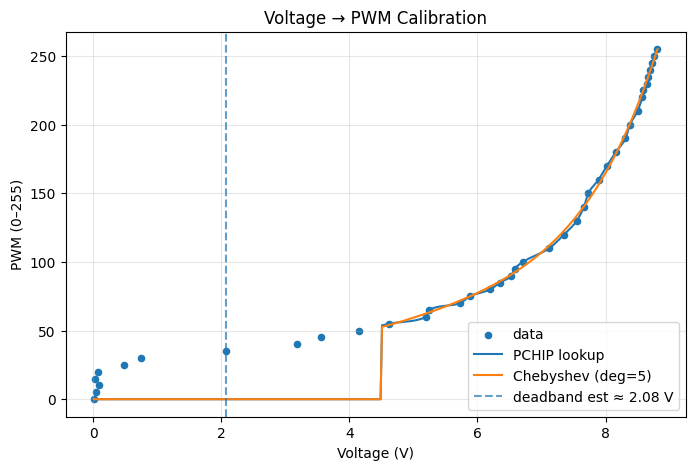

In [8]:
# --- SECTION 3: (Optional) Visualize Mapping ---
V_grid = np.linspace(float(map_df['voltage'].min()), float(map_df['voltage'].max()), 400)

plt.figure(figsize=(8,5))
plt.scatter(map_df['voltage'], map_df['pwm'], s=20, label='data')
plt.plot(V_grid, voltage_to_pwm(V_grid, method='lookup', round_to_int=False), label='PCHIP lookup')
if cheby_model is not None:
    plt.plot(V_grid, voltage_to_pwm(V_grid, method='cheby', round_to_int=False), label=f'Chebyshev (deg={cheby_fit["deg"]})')
plt.axvline(V_DEADBAND_EST, ls='--', alpha=0.7, label=f'deadband est ≈ {V_DEADBAND_EST:.2f} V')
plt.xlabel('Voltage (V)'); plt.ylabel('PWM (0–255)'); plt.title('Voltage → PWM Calibration')
plt.grid(True, alpha=0.3); plt.legend()
plt.show()

## SECTION 4 — Load Run Data & Preprocessing (your original)

In [9]:
# --- SECTION 4: Load run_minimal.csv & Preprocessing ---

# load csv
df = pd.read_csv(CSV_PATH)
df['time']    = pd.to_numeric(df['time'],    errors='coerce')
df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')
df['rpm']     = pd.to_numeric(df['rpm'],     errors='coerce')

# sampling
t_vals = df['time'].values
Ts = float(np.median(np.diff(t_vals))) if len(df) > 1 else 0.01
Ts = max(Ts, 1e-3)

# dead-zone (before plant) — keep your constants; you can flip USE_AUTO_DEADBAND=True above if preferred
VDB_POS, VDB_NEG, SOFT_ALPHA = VDB_POS_DEFAULT, VDB_NEG_DEFAULT, 0.00

def deadzone_map(u):
    u = np.asarray(u, dtype=float)
    vdb = np.where(u >= 0.0, VDB_POS, VDB_NEG)
    mag = np.abs(u)
    eff_mag = np.where(mag <= vdb, SOFT_ALPHA * mag, (mag - vdb) + SOFT_ALPHA * vdb)
    return np.sign(u) * eff_mag

df['u_eff'] = deadzone_map(df['voltage'].values)

# smooth rpm (for ID)
y_raw = df['rpm'].values
base_win = int(round(0.5 / Ts));  base_win += (base_win % 2 == 0)
base_win = max(5, min(base_win, len(df) - (len(df) % 2 == 0)))
y_id = savgol_filter(y_raw, window_length=base_win, polyorder=2, mode='interp')
df['rpm_id'] = y_id

print("Loaded main run and preprocessed.")

Loaded main run and preprocessed.


## SECTION 5 — Step Detection & Per-Step Fits (your original)

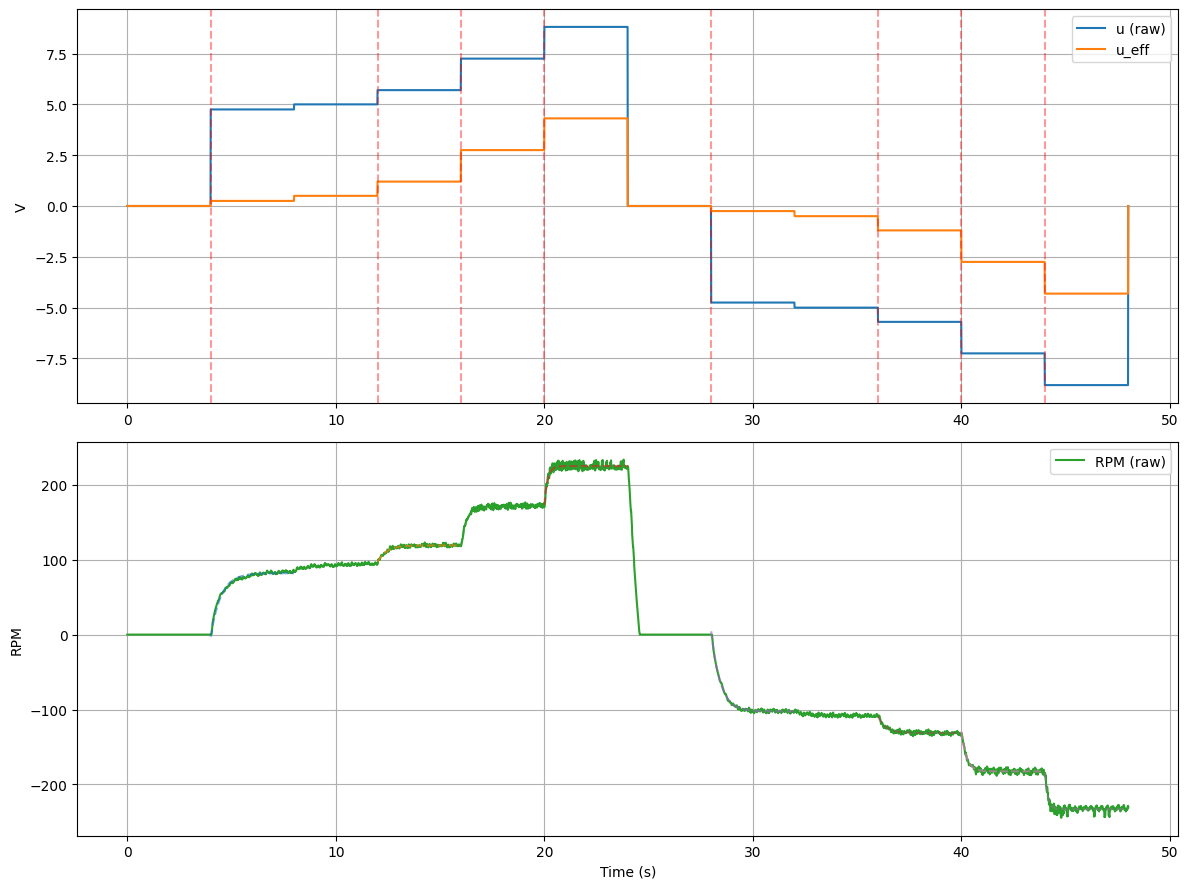

Candidates: ['Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Overall', 'Up_avg', 'Down_avg']


In [10]:
# --- SECTION 5: Step detection & per-step FO fits ---

# detect steps on raw voltage
thrV = max(0.2, 4.0 * stats.median_abs_deviation(np.diff(df["voltage"].values), scale='normal'))
changes = [0] + [i for i in range(1, len(df))
                 if abs(df["voltage"].iloc[i] - df["voltage"].iloc[i-1]) >= thrV] + [len(df)]

MIN_DV      = 0.5           # min raw Δu [V]
MIN_DWELLN  = int(2.0 / Ts) # min dwell samples

# tiny helpers
def step_model(t, dy, tau):         # 1st order step
    return dy * (1.0 - np.exp(-t / tau))

def compute_mae(y_true, y_pred):    # mean abs error
    return float(np.mean(np.abs(y_true - y_pred)))

def _savgol_len(n, prefer):         # safe odd window
    w = min(prefer, n if (n % 2 == 1) else (n - 1))
    if w < 5: w = 5
    if w % 2 == 0: w += 1
    return w

step_results = []

# quick visual
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
ax1.plot(df['time'], df['voltage'], label='u (raw)'); ax1.plot(df['time'], df['u_eff'], label='u_eff')
ax1.set_ylabel('V'); ax1.grid(True); ax1.legend()
ax2.plot(df['time'], y_raw, label='RPM (raw)', color='tab:green')
ax2.set_xlabel('Time (s)'); ax2.set_ylabel('RPM'); ax2.grid(True); ax2.legend()

prev_u = df['voltage'].iloc[0]
for seg in range(len(changes) - 1):
    s = changes[seg]
    e = changes[seg + 1] - 1
    if s > e: continue

    seg_df   = df.iloc[s:e+1].copy()
    t0       = seg_df['time'].iloc[0]
    t_seg    = seg_df['time'] - t0
    u_after  = seg_df['voltage'].iloc[0]
    u_before = prev_u
    du_raw   = u_after - u_before

    if len(seg_df) < MIN_DWELLN: prev_u = u_after; continue
    if abs(du_raw) < MIN_DV:     prev_u = u_after; continue

    raw_seg   = y_raw[s:e+1]
    prefer    = 101 if abs(du_raw) < 1.0 else 51
    win_len   = _savgol_len(len(raw_seg), prefer)
    y         = savgol_filter(raw_seg, window_length=win_len, polyorder=2, mode='interp')

    y0, yss   = float(y[0]), float(y[-1])
    dy_guess  = yss - y0
    if abs(dy_guess) < 5: prev_u = u_after; continue

    tau0 = max(0.05, min(2.0, (seg_df['time'].iloc[-1] - seg_df['time'].iloc[0]) / 3.0))
    p0   = [dy_guess, tau0]
    lb_tau, ub_tau = 0.02, 5.0
    if dy_guess >= 0: lb_dy, ub_dy = 0.3*dy_guess, 1.7*dy_guess
    else:             lb_dy, ub_dy = 1.7*dy_guess, 0.3*dy_guess

    du_eff = deadzone_map([u_after])[0] - deadzone_map([u_before])[0]

    try:
        popt, _ = curve_fit(step_model, t_seg, y - y0,
                            p0=p0, bounds=([lb_dy, lb_tau],[ub_dy, ub_tau]), maxfev=5000)
        dy_fit, tau_fit = float(popt[0]), float(popt[1])
        K_fit = dy_fit / du_eff if abs(du_eff) > 1e-6 else np.nan

        yhat = y0 + step_model(t_seg.values, dy_fit, tau_fit)
        mae  = compute_mae(y, yhat)
        if np.isnan(mae) or mae > 5: prev_u = u_after; continue

        step_results.append({
            'step_num': len(step_results) + 1,
            'start_time': float(t0),
            'start_idx': int(s), 'end_idx': int(e),
            'u_before': float(u_before), 'u_after': float(u_after),
            'delta_u': float(du_raw), 'delta_u_eff': float(du_eff),
            'y0': float(y0), 'y_ss': float(yss),
            'delta_y_fit': float(dy_fit), 'K': float(K_fit), 'tau': float(tau_fit),
            'mae_rpm': float(mae),
            'direction': seg_df['direction'].iloc[0] if 'direction' in seg_df.columns else 'up',
            'window_len': int(win_len)
        })

        # overlay fitted curve (optional)
        tt = np.linspace(0, t_seg.iloc[-1], 200)
        ax2.plot(t0 + tt, y0 + step_model(tt, dy_fit, tau_fit), '--', alpha=0.6)
        ax1.axvline(t0, color='r', ls='--', alpha=0.4)

    except Exception:
        pass

    prev_u = u_after

plt.tight_layout(); plt.show()
assert step_results, "No valid steps found."

# aggregate candidates
valid = [r for r in step_results if not np.isnan(r['K'])]
K_all   = [r['K'] for r in valid]
tau_all = [r['tau'] for r in valid]
overall_K, overall_tau = float(np.mean(K_all)), float(np.mean(tau_all))

def _dir(r):
    return (r['direction'].strip().lower() if isinstance(r['direction'], str)
            else ('up' if r['direction']>0 else 'down'))

up   = [r for r in valid if _dir(r)=='up']
down = [r for r in valid if _dir(r)=='down']

up_K   = float(np.mean([r['K'] for r in up]))   if up else np.nan
up_tau = float(np.mean([r['tau'] for r in up])) if up else np.nan
dn_K   = float(np.mean([r['K'] for r in down])) if down else np.nan
dn_tau = float(np.mean([r['tau'] for r in down])) if down else np.nan

# save per-step table
pd.DataFrame(step_results).to_csv(f'{OUT_DIR}/step_fits.csv', index=False)

# build candidates
candidates = [{'name': f"Step{r['step_num']}", 'K': r['K'], 'tau': r['tau']} for r in valid]
candidates += [{'name':'Overall','K':overall_K,'tau':overall_tau}]
if not np.isnan(up_K):   candidates += [{'name':'Up_avg','K':up_K,'tau':up_tau}]
if not np.isnan(dn_K):   candidates += [{'name':'Down_avg','K':dn_K,'tau':dn_tau}]

print("Candidates:", [c['name'] for c in candidates])

## SECTION 6 — Simulation Helpers (bias/delay search) (your original)

In [11]:
# --- SECTION 6: Simulation helpers (bias/delay) ---

# delay helper
def apply_delay(u, t, Td):
    if Td <= 1e-9: return np.asarray(u, dtype=float).copy()
    t = np.asarray(t, dtype=float); u = np.asarray(u, dtype=float)
    return np.interp(t, t - Td, u, left=u[0], right=u[-1])

# linear plant response y for input u
def sim_full_response(K, tau, u_input, t_input):
    sys = TransferFunction([K], [tau, 1.0])
    _, yout, _ = lsim(sys, U=u_input, T=t_input, X0=0.0)
    return yout

# fast search for (Bpos, Bneg, D) using 3 sims per delay
def fit_signed_bias_delay_fast(K, tau, u_eff, t, y_true, mask,
                               bias_pos_bounds=(-5.0, 5.0), bias_neg_bounds=(-5.0, 5.0),
                               delay_bounds=(0.0, 0.30),
                               coarse_B_n=17, coarse_D_n=19,
                               fine_B_n=9, fine_D_n=9):
    idx = np.where(mask)[0]
    best = {'Bpos':0.0,'Bneg':0.0,'D':0.0,'mae':np.inf}

    Bs_pos = np.linspace(*bias_pos_bounds, coarse_B_n)
    Bs_neg = np.linspace(*bias_neg_bounds, coarse_B_n)
    Ds     = np.linspace(*delay_bounds,    coarse_D_n)

    for D in Ds:
        uD = apply_delay(u_eff, t, D)
        pos = (uD > 0).astype(float); neg = (uD < 0).astype(float)

        y_u   = sim_full_response(K, tau, uD,   t)
        y_pos = sim_full_response(K, tau, pos,  t)
        y_neg = sim_full_response(K, tau, neg,  t)

        yu, yp, yn, yt = y_u[idx], y_pos[idx], y_neg[idx], y_true[idx]
        for Bp in Bs_pos:
            base = yu - Bp*yp
            yhat = base[:,None] + yn[:,None]*Bs_neg[None,:]
            mae_vec = np.mean(np.abs(yt[:,None] - yhat), axis=0)
            j = int(np.argmin(mae_vec)); mae = float(mae_vec[j])
            if mae < best['mae']:
                best.update({'Bpos':float(Bp),'Bneg':float(Bs_neg[j]),'D':float(D),'mae':mae})

    # fine
    Bp0,Bn0,D0 = best['Bpos'], best['Bneg'], best['D']
    Bs_pos_f = np.linspace(Bp0-0.30, Bp0+0.30, fine_B_n)
    Bs_neg_f = np.linspace(Bn0-0.30, Bn0+0.30, fine_B_n)
    Ds_f     = np.linspace(max(delay_bounds[0], D0-0.05),
                           min(delay_bounds[1], D0+0.05), fine_D_n)

    for D in Ds_f:
        uD = apply_delay(u_eff, t, D)
        pos = (uD > 0).astype(float); neg = (uD < 0).astype(float)
        y_u   = sim_full_response(K, tau, uD,   t)
        y_pos = sim_full_response(K, tau, pos,  t)
        y_neg = sim_full_response(K, tau, neg,  t)
        yu, yp, yn, yt = y_u[idx], y_pos[idx], y_neg[idx], y_true[idx]
        for Bp in Bs_pos_f:
            base = yu - Bp*yp
            yhat = base[:,None] + yn[:,None]*Bs_neg_f[None,:]
            mae_vec = np.mean(np.abs(yt[:,None] - yhat), axis=0)
            j = int(np.argmin(mae_vec)); mae = float(mae_vec[j])
            if mae < best['mae']:
                best.update({'Bpos':float(Bp),'Bneg':float(Bs_neg_f[j]),'D':float(D),'mae':mae})

    return best['Bpos'], best['Bneg'], best['D'], best['mae']

# per-step sim (no bias/delay)
def sim_step_response(t, du_raw, K, tau, y0, u_before=None, u_after=None):
    if (u_before is not None) and (u_after is not None):
        du_eff = deadzone_map([u_after])[0] - deadzone_map([u_before])[0]
    else:
        du_eff = du_raw
    return y0 + (K*du_eff) * (1.0 - np.exp(-t / max(tau, 1e-9)))

## SECTION 7 — Cross-Validation (Bias/Delay), Overlays, Heatmap (your original)

In [12]:
# --- SECTION 7: Cross-Validation, Overlays, Heatmap ---

t_stair_start = 20.0
mask_full = df['time'].values >= t_stair_start
y_true_full = df['rpm_id'].values
u_eff_full  = df['u_eff'].values
t_full      = df['time'].values

scores = []
print("Cross-validation (signed bias + delay):")
for cand in candidates:
    name, K, tau = cand['name'], float(cand['K']), float(cand['tau'])
    Bp, Bn, D, mae_overall = fit_signed_bias_delay_fast(
        K, tau, u_eff_full, t_full, y_true_full, mask_full,
        bias_pos_bounds=(-5,5), bias_neg_bounds=(-5,5),
        delay_bounds=(0.0,0.30), coarse_B_n=17, coarse_D_n=19, fine_B_n=9, fine_D_n=9
    )

    # step-wise CV (no bias/delay)
    maes = []
    for r in step_results:
        if name.startswith('Step') and int(name[4:]) == r['step_num']: continue
        s,e = r['start_idx'], r['end_idx']
        t_seg = df['time'].iloc[s:e+1].values - df['time'].iloc[s]
        y_true = df['rpm_id'].iloc[s:e+1].values
        y0 = r['y0']
        y_sim = sim_step_response(t_seg, r['delta_u'], K, tau, y0, r['u_before'], r['u_after'])
        maes.append(compute_mae(y_true, y_sim))

    avg_steps = float(np.mean(maes)) if maes else np.nan
    combined  = 0.5*mae_overall + 0.5*avg_steps if not np.isnan(avg_steps) else mae_overall

    scores.append({'Candidate':name,
                   'Overall MAE (RPM)':mae_overall,
                   'Avg Other Steps MAE (RPM)':avg_steps,
                   'N Steps':len(maes),
                   'Combined MAE (RPM)':combined,
                   'U_bias_pos (V)':Bp, 'U_bias_neg (V)':Bn, 'T_delay (s)':D})

scores_df = pd.DataFrame(scores).round(2)
scores_df.to_csv(f'{OUT_DIR}/cross_val_scores.csv', index=False)
scores_df

Cross-validation (signed bias + delay):


,Candidate,Overall MAE (RPM),Avg Other Steps MAE (RPM),N Steps,Combined MAE (RPM),U_bias_pos (V),U_bias_neg (V),T_delay (s)
0,Step1,270.00,293.03,7,281.52,3.60,0.78,0.01
1,Step2,4.06,25.97,7,15.01,-2.90,-3.05,0.02
2,Step3,3.59,24.30,7,13.94,-2.10,-2.50,0.00
3,Step4,3.27,23.91,7,13.59,-2.42,-2.72,0.00
4,Step5,349.29,383.95,7,366.62,3.75,0.85,0.00
5,Step6,3.38,25.30,7,14.34,-2.82,-2.98,0.00
6,Step7,3.16,23.92,7,13.54,-2.28,-2.65,0.00
7,Step8,4.29,24.58,7,14.43,-2.98,-3.05,0.00
8,Overall,78.31,90.30,8,84.30,2.42,0.08,0.00
9,Up_avg,68.88,81.01,8,74.94,2.17,0.00,0.00


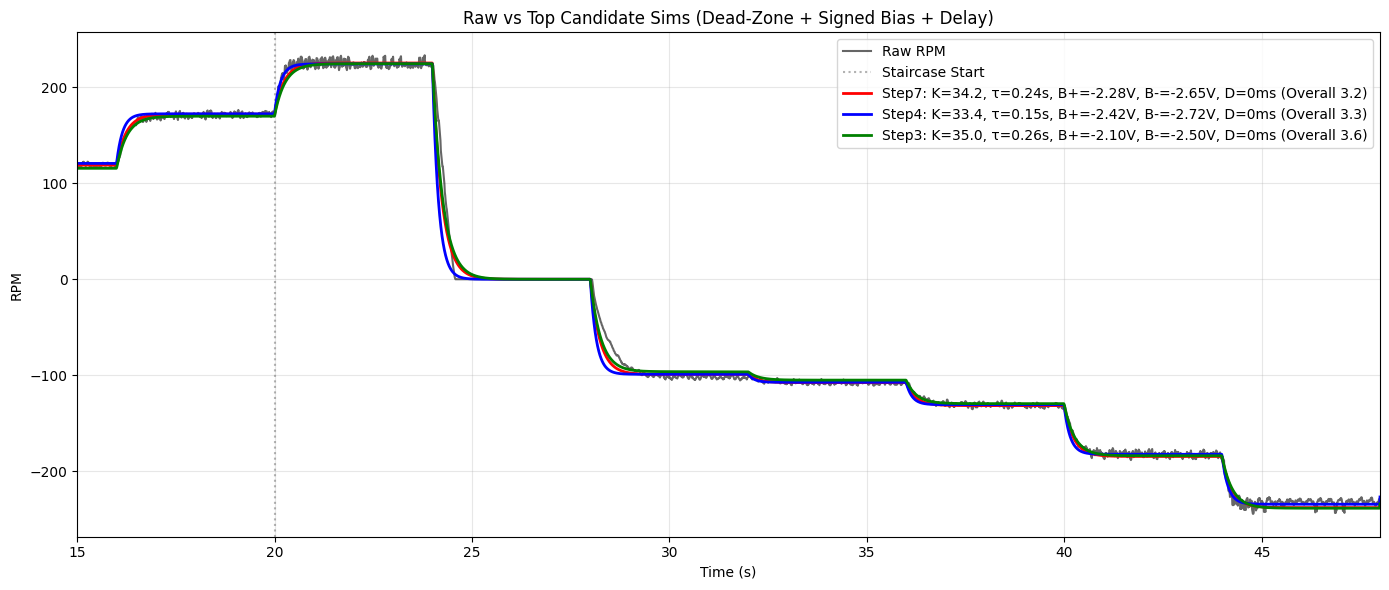

In [13]:
# --- SECTION 7B: Overlay of Top-3 Fits ---
top = scores_df.nsmallest(3, 'Combined MAE (RPM)')

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['time'], df['rpm'].values, 'k-', alpha=0.6, label='Raw RPM', lw=1.5)
ax.axvline(t_stair_start, color='gray', ls=':', alpha=0.6, label='Staircase Start')

colors = ['r','b','g']
for i, (_, row) in enumerate(top.iterrows()):
    name = row['Candidate']
    idx  = [c['name'] for c in candidates].index(name)
    K    = candidates[idx]['K']; tau = candidates[idx]['tau']
    Bp   = float(row['U_bias_pos (V)']); Bn = float(row['U_bias_neg (V)']); D = float(row['T_delay (s)'])
    y_sim = (lambda K,tau,Bp,Bn,D: (
        lambda u_eff, t: (
            # reuse overlay builder
            (lambda uD, pos, neg: (
                sim_full_response(K, tau, uD, t)
                - Bp*sim_full_response(K, tau, pos, t)
                + Bn*sim_full_response(K, tau, neg, t)
            ))(apply_delay(u_eff, t, D), (apply_delay(u_eff, t, D) > 0).astype(float), (apply_delay(u_eff, t, D) < 0).astype(float))
        )
    ))(K,tau,Bp,Bn,D)(df['u_eff'].values, df['time'].values)
    ax.plot(df['time'], y_sim, colors[i], lw=2,
            label=f"{name}: K={K:.1f}, τ={tau:.2f}s, B+={Bp:+.2f}V, B-={Bn:+.2f}V, D={int(D*1e3)}ms "
                  f"(Overall {row['Overall MAE (RPM)']:.1f})")
ax.set_xlabel('Time (s)'); ax.set_ylabel('RPM'); ax.set_xlim(15, df['time'].max())
ax.set_title('Raw vs Top Candidate Sims (Dead-Zone + Signed Bias + Delay)')
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.savefig(f'{OUT_DIR}/full_overlays_top3.png', dpi=150); plt.show()

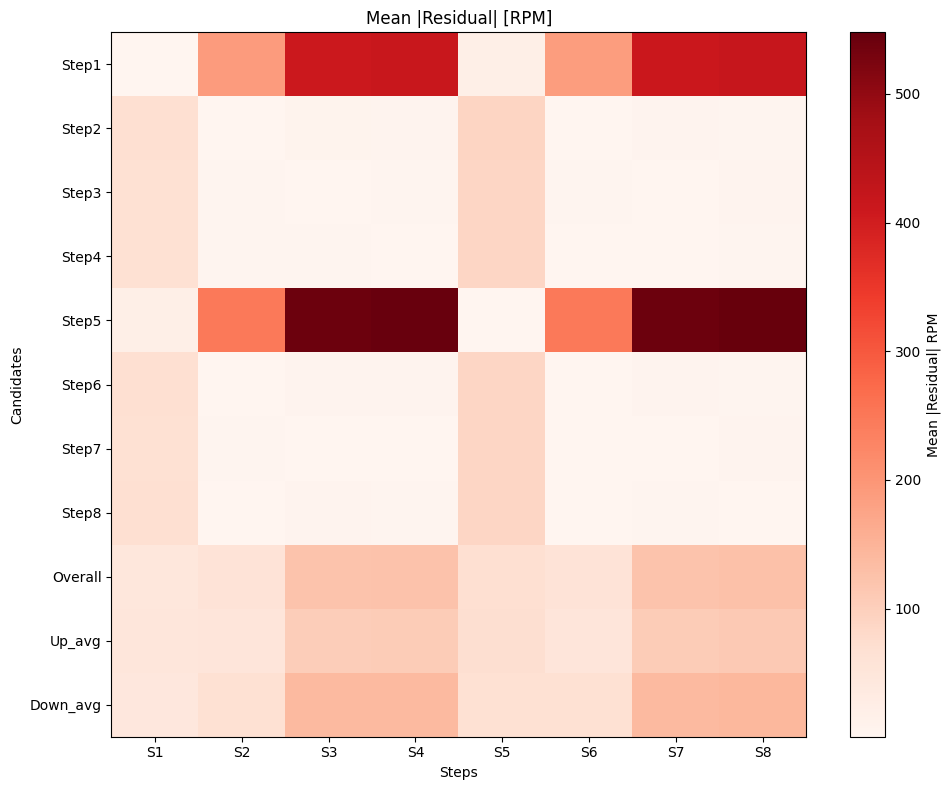

In [14]:
# --- SECTION 7C: Residual Heatmap (candidate vs step) ---
res_matrix = np.full((len(candidates), len(step_results)), np.nan)
for ci, cand in enumerate(candidates):
    for si, r in enumerate(step_results):
        s,e = r['start_idx'], r['end_idx']
        t_seg = df['time'].iloc[s:e+1].values - df['time'].iloc[s]
        y_true = df['rpm_id'].iloc[s:e+1].values
        y0 = r['y0']
        y_sim = sim_step_response(t_seg, r['delta_u'], cand['K'], cand['tau'], y0,
                                  r['u_before'], r['u_after'])
        res_matrix[ci, si] = np.mean(np.abs(y_true - y_sim))

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(res_matrix, cmap='Reds', aspect='auto')
ax.set_xticks(range(len(step_results)))
ax.set_xticklabels([f"S{r['step_num']}" for r in step_results])
ax.set_yticks(range(len(candidates)))
ax.set_yticklabels([c['name'] for c in candidates])
ax.set_xlabel('Steps'); ax.set_ylabel('Candidates'); ax.set_title('Mean |Residual| [RPM]')
plt.colorbar(im, ax=ax, label='Mean |Residual| RPM')
plt.tight_layout(); plt.savefig(f'{OUT_DIR}/residuals_heatmap.png', dpi=150); plt.show()

## SECTION 8 — Final Parameters + Residuals (your original)

Final plant:
  Dead-zone: +4.50 V / -4.50 V (alpha=0.00)
  Signed bias: B+=-2.280 V, B-=-2.650 V
  Delay: 0 ms
  G(s) = 34.207 / (0.241 s + 1)


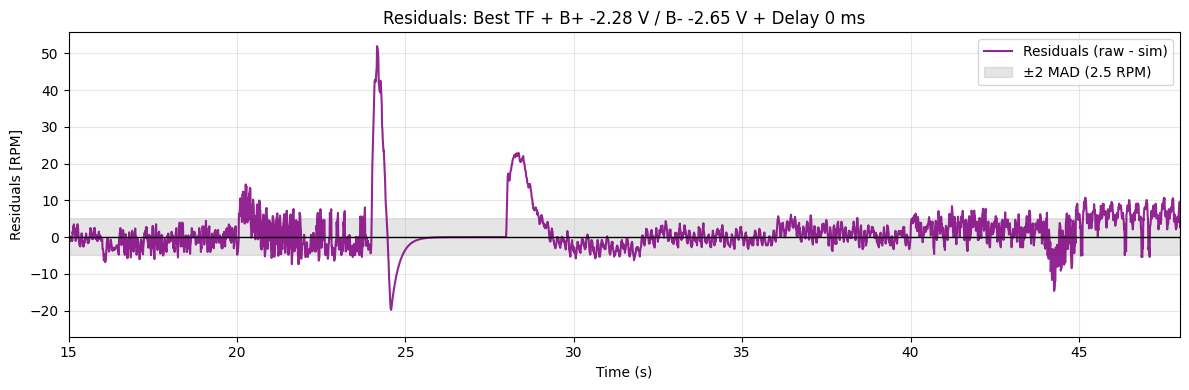

In [15]:
# --- SECTION 8: Final parameters + residuals ---

best_row  = scores_df.loc[scores_df['Combined MAE (RPM)'].idxmin()]
best_name = best_row['Candidate']
cidx      = [c['name'] for c in candidates].index(best_name)
best_K, best_tau = candidates[cidx]['K'], candidates[cidx]['tau']
best_Bp = float(best_row['U_bias_pos (V)'])
best_Bn = float(best_row['U_bias_neg (V)'])
best_D  = float(best_row['T_delay (s)'])

print("Final plant:")
print(f"  Dead-zone: +{VDB_POS:.2f} V / -{VDB_NEG:.2f} V (alpha={SOFT_ALPHA:.2f})")
print(f"  Signed bias: B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V")
print(f"  Delay: {best_D*1e3:.0f} ms")
print(f"  G(s) = {best_K:.3f} / ({best_tau:.3f} s + 1)")

# export params
pd.DataFrame({
    'Best_Candidate':[best_name],
    'Best_K':[best_K], 'Best_tau':[best_tau],
    'U_bias_pos_V':[best_Bp], 'U_bias_neg_V':[best_Bn], 'T_delay_s':[best_D],
    'DeadZone_PosV':[VDB_POS], 'DeadZone_NegV':[VDB_NEG], 'SoftAlpha':[SOFT_ALPHA],
    'TF_str':[f"{best_K:.3f} / ({best_tau:.3f} s + 1)  with  B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V, D={best_D:.3f} s"]
}).to_csv(f'{OUT_DIR}/recommended_tf_with_bias_delay.csv', index=False)

# residuals using best signed bias + delay
def overlay_sim_response_signed(K, tau, u_eff, t, Bpos, Bneg, D):
    uD = apply_delay(u_eff, t, D)
    pos = (uD > 0).astype(float); neg = (uD < 0).astype(float)
    y_u   = sim_full_response(K, tau, uD,   t)
    y_pos = sim_full_response(K, tau, pos,  t)
    y_neg = sim_full_response(K, tau, neg,  t)
    return y_u - Bpos*y_pos + Bneg*y_neg

y_sim_best = overlay_sim_response_signed(best_K, best_tau, df['u_eff'].values, df['time'].values,
                                         best_Bp, best_Bn, best_D)
resids = df['rpm'].values - y_sim_best
mask = df['time'].values >= 20.0
mad = stats.median_abs_deviation(resids[mask])

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['time'], resids, color='purple', alpha=0.85, label='Residuals (raw - sim)')
ax.axhline(0, color='k', lw=1)
ax.fill_between(df['time'], -2*mad, 2*mad, color='gray', alpha=0.2, label=f'±2 MAD ({mad:.1f} RPM)')
ax.set_xlabel('Time (s)'); ax.set_ylabel('Residuals [RPM]')
ax.set_title(f'Residuals: Best TF + B+ {best_Bp:+.2f} V / B- {best_Bn:+.2f} V + Delay {int(best_D*1e3)} ms')
ax.grid(True, alpha=0.3); ax.legend(); ax.set_xlim(15, df['time'].max())
plt.tight_layout(); plt.savefig(f'{OUT_DIR}/final_residuals.png', dpi=150); plt.show()

## SECTION 9 — (Optional) Export LUT & Chebyshev Params

In [16]:
# --- SECTION 9: (Optional) Export LUT & Chebyshev params for Simulink/Docs ---

# LUT export (Voltage breakpoints & PWM values)
lut_export = pd.DataFrame({'Voltage_breakpoints': V_map, 'PWM_values': P_map})
lut_export.to_csv(f'{OUT_DIR}/voltage_to_pwm_LUT.csv', index=False)

# Chebyshev export (if fitted)
if cheby_model is not None:
    import json, pathlib
    cheby_info = {
        'degree': int(cheby_fit['deg']),
        'domain': [float(cheby_model.domain[0]), float(cheby_model.domain[1])],
        'coefficients': [float(c) for c in cheby_model.coef],
        'deadband_voltage_default_pos': float(VDB_POS_DEFAULT),
        'deadband_voltage_default_neg': float(VDB_NEG_DEFAULT),
        'deadband_voltage_estimated': float(V_DEADBAND_EST),
    }
    pathlib.Path(f'{OUT_DIR}/voltage_to_pwm_cheby.json').write_text(json.dumps(cheby_info, indent=2))

print("Exports saved to:", OUT_DIR)

Exports saved to: /content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis
